In [1]:
'''
1. Linear approximate exon distribution peak VS intron density 
2. Fit gamma to exon length distribution
refined ES parameter parsing
'''
## use ipython parallel programming 
from IPython.parallel import Client
rc = Client()
dview = rc[:]


import pandas as pd; dview.execute("import pandas as pd")
import numpy as np; dview.execute("import numpy as np")
from scipy import stats


import matplotlib.pylab as plt
import os
%matplotlib inline


# The path where all the GeneMark-ES 4th run models located
modelFilePath = "/home/richard/largeDataSet/ES_Run_modfileAug2015/"
modelFileNames = os.listdir(modelFilePath)

# full data
fulldata = pd.read_csv("../1_DataSmall/fullTableInfoGff3GffRNAESwithDensity20150829.csv", index_col='shortName' )
# add Pneji1 to fulldata for passing ES run
fulldata.loc['Pneji1','ES'] = 'pass'
fulldata.to_csv("../1_DataSmall/fullTableInfoGff3GffRNAESwithDensity20150909.csv",index = None)

class ESParamParse():
    """Take in 4th run of model file as text and extract info"""
    _DISTR_TYPE= {
        'INITIAL'  :('$INITIAL_DISTR', range(3,10001)),
        'EXON'     :('$EXON_DISTR',range(3,10001)),
        'TERMINAL' : ('$TERMINAL_DISTR', range(3,10001)),
        'SINGLE'   :('$SINGLE_DISTR', range(300,10000)),
        'INTRON'   :('$INTRON_DISTR',range(20,3001)),
        'BP_ACC'   :('$BP_ACC_DISTR',range(2,41)),
        'DON_BP'   :('$DON_BP_DISTR',range(5,3001))
    }
    
    def __init__(self, filename):
        self.f = open(filename)
    def close(self):
        '''close file connection'''
        self.f.close()
        
    def maxPosition(self, distrType):
        '''
        return the position with the highest probability
        '''
        # decompose the distrbutionType varibable to distribution type/tag and min_max length range
        TAG, RANGE = self._DISTR_TYPE[distrType]
        # accqure the max length signal
        LENGTH = RANGE[-1]

        # capture length distribution
        lengthData = []
        switch = False
        for line in self.f:
            if switch:
                lengthData.append(line)
            if TAG in line:
                switch = True
            if switch and "{}\t".format(LENGTH) in line:
                switch = False
                break
        lengthData = map(lambda line: line.rstrip().split("\t"), lengthData)
        positionProbabilityPair = map(lambda (a,b): (int(a), float(b)), lengthData)
        df = pd.DataFrame(positionProbabilityPair, columns=['position','probability']) 
        # return position of peak probability
        return df.position[np.argmax(df.probability)]
    
    def getLengthDistribution(self, distrType = 'EXON', probAcc = 0.95):

            '''
            input: Optional
            probAcc, probability accumulation, default = 0.9
            distrType, one of the six length distribution type

            return: dataframe with probability and their position(as two columns) that take up 0.95 probability(default)

            '''
            # decompose the distrbutionType varibable to distribution type/tag and min_max length range
            TAG, RANGE = self._DISTR_TYPE[distrType]
            # accqure the max length signal
            LENGTH = RANGE[-1]

            # capture length distribution
            lengthData = []
            switch = False
            for line in self.f:
                if switch:
                    lengthData.append(line)
                if TAG in line:
                    switch = True
                if switch and "{}\t".format(LENGTH) in line:
                    switch = False
                    break
            lengthData = map(lambda line: line.rstrip().split("\t"), lengthData)
            positionProbabilityPair = map(lambda (a,b): (int(a), float(b)), lengthData)

            df = pd.DataFrame(positionProbabilityPair, columns=['position','probability']) 

            #sort probability in reverse order, capture distribution that take up to probAcc
            df.sort_index(axis = 0, ascending = False, by = ['probability'], inplace = True)
            df['accProb'] = df.probability.cumsum()
            idx  = df.accProb < probAcc
            df_sub = df[idx].copy()
            #sort index to original order, output data frame
            df_sub.sort_index(axis = 0, by = ['position'], inplace = True)
            return df_sub[['position','probability']]

    
dview.push({'ESParamParse':ESParamParse,'modelFilePath':modelFilePath,'modelFileNames':modelFileNames})

## create data frame that collect all the peak probabilities
shortNames = map(lambda x: x.split(".")[0], modelFileNames)
dfPeakProbs = pd.DataFrame({'shortName': shortNames})
dfPeakProbs.index = shortNames

In [2]:
## First of all, find linear relation between exon peak probability and intron density
exonPeakProbMap = dview.map(lambda modelName: ESParamParse(modelFilePath+modelName).maxPosition('EXON'), modelFileNames)
exonPeakProbReduce = exonPeakProbMap.get()
dfPeakProbs['exonPeakPosition'] = exonPeakProbReduce
fulldata[['intronDensityGff3','intronDensityGff']].apply(pd.isnull).sum(0) # we saw Gff have more intron density data

intronDensityGff3    142
intronDensityGff      25
dtype: int64

In [3]:
# left join to add intron density column
dfPeakProbs = dfPeakProbs.join(fulldata['intronDensityGff'])

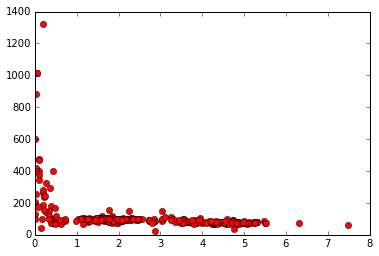

In [4]:
# with intron density < 1 species included, they are probably noises
plt.plot(dfPeakProbs.intronDensityGff,dfPeakProbs.exonPeakPosition,'ro')

In [5]:
# create index with intron density > 1
idx = dfPeakProbs.intronDensityGff > 1
dfPeakProbs = dfPeakProbs[idx]

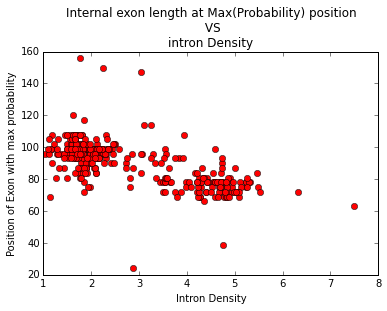

In [6]:
#visualize exon VS intron density
plt.plot(dfPeakProbs.intronDensityGff,dfPeakProbs.exonPeakPosition,'ro')
plt.xlabel("Intron Density")
plt.ylabel("Position of Exon with max probability")
# plt.ylim([20,200])
plt.title("Internal exon length at Max(Probability) position \n VS \nintron Density")

In [7]:
######################
########   linear fitting: x = intron density, y = exon length
slope, intercept, r_value, p_value, std_err = \
        stats.linregress(dfPeakProbs.intronDensityGff,dfPeakProbs.exonPeakPosition)

In [8]:
## generate two points on the regression line and plot it on the previous graph
x_vec = (1,7)
y_vec = map(lambda x: intercept + x * slope, x_vec)

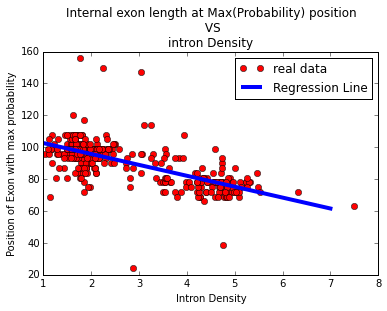

In [9]:
#visualize exon VS intron density with regression line
plt.plot(dfPeakProbs.intronDensityGff,dfPeakProbs.exonPeakPosition,'ro', label = "real data")
plt.plot(x_vec,y_vec,"b-",lw = 4,label = 'Regression Line')
plt.xlabel("Intron Density")
plt.ylabel("Position of Exon with max probability")
plt.legend()
# plt.ylim([20,200])
plt.title("Internal exon length at Max(Probability) position \n VS \nintron Density")

In [10]:
### For each intron density we can 
##  1. find the related peak point, that 
##  2. build gamma distribution based on peak probability location and intron density

In [11]:
## how to fit a gamma distribution
# set sample size, for example 100000
# time each probability with sample size and take the integer value
# fit gamma distrbution with the lengths generated

In [12]:
## save compare png to file
fittingPath = "/home/richard/research/1_DataSmall/Plots/gammaFitting/exon/"

In [32]:
def fit_and_compare(shortName, accProb = .88, distriType = 'EXON',size = 10000, demo = True):
    test1 = ESParamParse(modelFilePath+'{}.ES_C_4.mod'.format(shortName))
    df_test = test1.getLengthDistribution('EXON',accProb)
    
    
    # generate sample points for gamma to fit
    counts = map(lambda n: int(round(n)),df_test.probability*size)
    df_test['counts'] = counts
    
    # multicore version
    dview.push({'df_test':df_test})
    lengths_map = dview.map(lambda i: df_test.counts[i]*
                  [df_test.position[i]],
                  df_test.index)
    lengths_reduce = lengths_map.get()
    lengths = reduce(lambda a,b : a+b,lengths_reduce)
    
    
    ## gamma fitting
    shape,loc,scale = stats.gamma.fit(lengths)
    print shape,scale
    
    plt.plot(df_test.position,df_test.probability, label = 'ES Exon Lenght Distribution')
    plt.plot(range(1000),stats.gamma.pdf(range(1000),shape,loc,scale), 'r',label = 'Gamma Fitting')
    longName = " ".join(fulldata.ix[shortName]['longName'].split()[:2])
    gc = fulldata.ix[shortName]['gc']
    intronDensity = fulldata.ix[shortName]['intronDensityGff']
    plt.title("{} Exon length distribuiton\ngc: {},  Intron Density: {}".format(longName,gc,intronDensity))
    
    plt.legend()
    if demo is False:
        plt.savefig(fittingPath+shortName+'Fitting.png')
        plt.close()

In [33]:
fit_and_compare('Schpo1',accProb=0.82, demo = False)

2.01642392721 86.0644737811


In [34]:
fit_and_compare('Neucr2',accProb=0.85, demo = False)

1.41912768595 215.048733093


In [35]:
fit_and_compare('Pneji1',accProb=0.88, demo = False)

2.6903937102 61.7311474337


1.37196981524 213.197060336


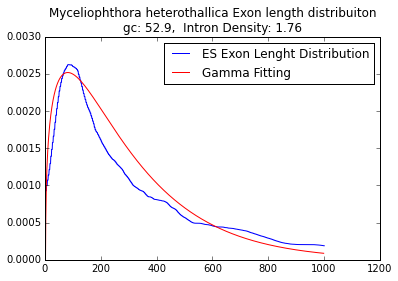

In [36]:
fit_and_compare(dfPeakProbs.index[1])

1.48954484403 185.337480725


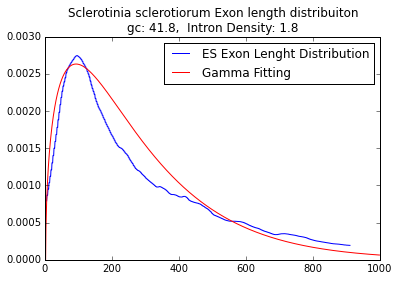

In [18]:
fit_and_compare(dfPeakProbs.index[2])

1.35290910841 237.874088388


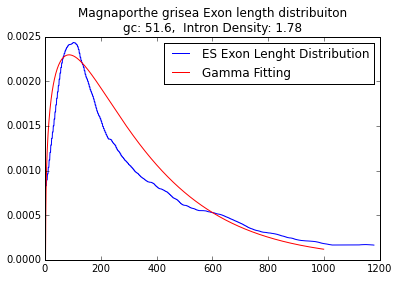

In [19]:
fit_and_compare(dfPeakProbs.index[3])

2.1458625911 46.7865292327


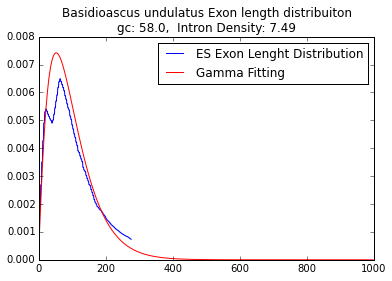

In [20]:
fit_and_compare(dfPeakProbs.index[4])

1.80552772155 134.715403684


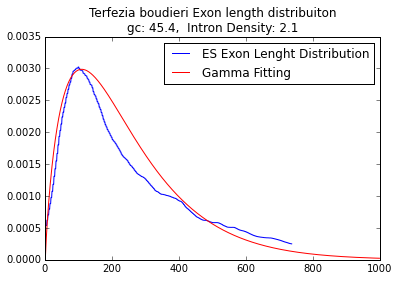

In [21]:
fit_and_compare(dfPeakProbs.index[5])

In [22]:
######## Testing codes

# test1 = ESParamParse(modelFilePath+'Aaoar1.ES_C_4.mod')
test1 = ESParamParse(modelFilePath+'Pneji1.ES_C_4.mod')
# test1 = ESParamParse(modelFilePath+'Schpo1.ES_C_4.mod')
df_test = test1.getLengthDistribution('EXON',.88)

In [23]:
# generate sample points for gamma to fit
size = 100000
counts = map(lambda n: int(round(n)),df_test.probability*size)

In [24]:
df_testWithCount = df_test.copy()
df_testWithCount['counts'] = counts

In [25]:
# single core version
# lengths = reduce(lambda a,b: a+b,map(lambda i: df_testWithCount.counts[i]*
#               [df_testWithCount.position[i]],
#               df_testWithCount.index))

In [26]:
# multicore version
dview.push({'df_testWithCount':df_testWithCount})
lengths_map = dview.map(lambda i: df_testWithCount.counts[i]*
              [df_testWithCount.position[i]],
              df_testWithCount.index)
lengths_reduce = lengths_map.get()
lengths = reduce(lambda a,b : a+b,lengths_reduce)

In [27]:
## gamma fitting
shape,loc,scale = stats.gamma.fit(lengths)

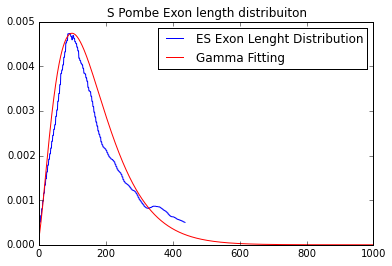

In [28]:
## comparison
plt.plot(df_test.position,df_test.probability, label = 'ES Exon Lenght Distribution')
plt.plot(range(1000),stats.gamma.pdf(range(1000),shape,loc,scale), 'r',label = 'Gamma Fitting')
plt.title("S Pombe Exon length distribuiton")
plt.legend()